# Module 8: Deep Learning with PyTorch

This notebook contains a basic neural net-based recommendation system based on the principle described in _Mastering PyTorch_ (Jha 2024).  I performed a basic experiment by modifying various hyperparameters to see how the recommender system would respond.

## Code source
The majority of the code in this notebook has been copied or adapted from the course textbook, _Mastering PyTorch_ (Jha 2024).  A [Github repository](https://github.com/arj7192/MasteringPyTorchV2) also exists.

Jha, Ashish Ranjan. 2024. _Mastering PyTorch: Create and Deploy Deep Learning Models from CNNs to Multimodal Models, LLMs, and Beyond_. Second edition. Birmingham: packt.

### Import Packages and Data

In [1]:
import math
import copy
from itertools import zip_longest

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch import optim

In [2]:
DATA_DIR = "../../rec_systems/08_module/data/ml-latest-small/"

ratings = pd.read_csv(DATA_DIR + 'ratings.csv',
                      sep=',')

movies = pd.read_csv(DATA_DIR + 'movies.csv',
                    sep=',')

minmax = ratings.rating.min(), ratings.rating.max()
ratings = ratings.merge(movies[["movieId", "title"]], on="movieId")
ratings.timestamp = pd.to_datetime(ratings.timestamp, unit = "s")

## Basic Exploratory Analysis

1. Distribution of ratings
2. Top rated movies with at least 10 ratings
3. Mean rating by month

Text(0, 0.5, 'Count')

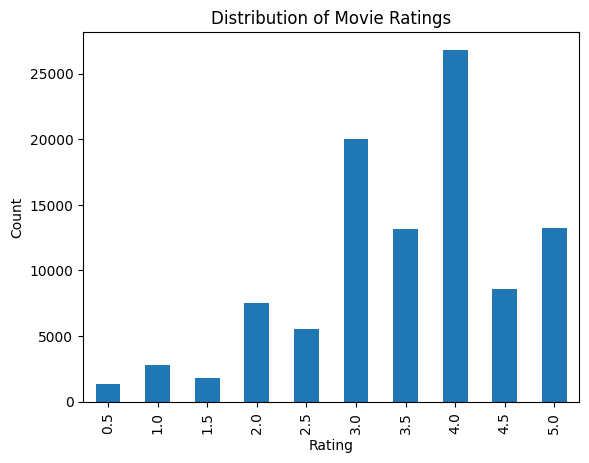

In [3]:
rating_counts = ratings['rating'].value_counts().sort_index()

rating_counts.plot(kind='bar')

plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

In [4]:
movie_stats = ratings.groupby('movieId').agg(
    rating_count=('rating', 'count'),
    average_rating=('rating', 'mean')
).reset_index()

popular_movies = movie_stats[movie_stats['rating_count'] >= 10]

top_movies = popular_movies.merge(movies, on='movieId')

top_movies = top_movies.sort_values(by='average_rating',
                                    ascending = False)

print(top_movies[['title', 'average_rating', 'rating_count']].head(10))

                                      title  average_rating  rating_count
411                   Secrets & Lies (1996)        4.590909            11
1186    Guess Who's Coming to Dinner (1967)        4.545455            11
456                   Paths of Glory (1957)        4.541667            12
441        Streetcar Named Desire, A (1951)        4.475000            20
871        Celebration, The (Festen) (1998)        4.458333            12
484                              Ran (1985)        4.433333            15
158        Shawshank Redemption, The (1994)        4.429022           317
377                  His Girl Friday (1940)        4.392857            14
722   All Quiet on the Western Front (1930)        4.350000            10
1190                    Hustler, The (1961)        4.333333            18


Text(0, 0.5, 'Average Rating')

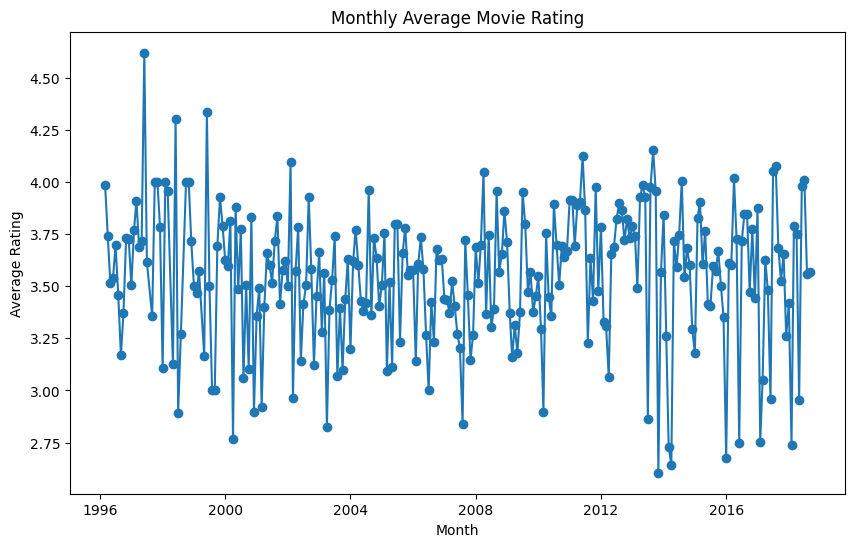

In [6]:
ratings['year_month'] = ratings['timestamp'].dt.to_period('M')
monthly_avg = ratings.groupby('year_month')['rating'].mean()
monthly_avg.index = monthly_avg.index.to_timestamp()

plt.figure(figsize=(10, 6))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
plt.title('Monthly Average Movie Rating')
plt.xlabel('Month')
plt.ylabel('Average Rating')

In [7]:
def create_dataset(ratings, top=None):
    if top is not None:
        ratings.groupby('userId')['rating'].count()
    
    unique_users = ratings.userId.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = ratings.userId.map(user_to_index)
    
    unique_movies = ratings.movieId.unique()
    movie_to_index = {old: new for new, old in enumerate(unique_movies)}
    new_movies = ratings.movieId.map(movie_to_index)
        
    n_users = unique_users.shape[0]
    n_movies = unique_movies.shape[0]
    
    X = pd.DataFrame({'user_id': new_users, 'movie_id': new_movies})
    y = ratings['rating'].astype(np.float32)
    return (n_users, n_movies), (X, y), (user_to_index, movie_to_index)

(n, m), (X, y), (user_to_index, movie_to_index) = create_dataset(ratings)

### Create a class to load the data

In [8]:
class ReviewsIterator: 
    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)
        
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
            
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

def batches(X, y, bs=29, shuffle=True):
    for xb, yb in ReviewsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1) 

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

### Define the EmbeddingsNet model 

In [10]:
class EmbeddingNet(nn.Module):
    """
    Creates a dense network with embedding layers.
    
    Args:
    
        n_users:            
            Number of unique users in the dataset.

        n_movies: 
            Number of unique movies in the dataset.

        n_factors: 
            Number of columns in the embeddings matrix.

        embedding_dropout: 
            Dropout rate to apply right after embeddings layer.

        hidden:
            A single integer or a list of integers defining the number of 
            units in hidden layer(s).

        dropouts: 
            A single integer or a list of integers defining the dropout 
            layers rates applyied right after each of hidden layers.
            
    """
    def __init__(self, n_users, n_movies,
                 n_factors=50, embedding_dropout=0.02, 
                 hidden=10, dropouts=0.2):
        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]
        
        def gen_layers(n_in):
            """
            A generator that yields a sequence of hidden layers and 
            their activations/dropouts.
            
            Note that the function captures `hidden` and `dropouts` 
            values from the outer scope.
            """
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)
            
            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out
            
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()
        
    def forward(self, users, movies, minmax=None):
        features = torch.cat([self.u(users), self.m(movies)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        return out
    
    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values.
        """
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)
    
    
def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')

### Define a model training function

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
def train_model(net, lr = 1e-5, wd = 1e-5, bs = 200, n_epochs = 20, patience = 10, no_improvements = 0):
    best_loss = np.inf
    best_weights = None
    history = []

    net.to(device)
    criterion = nn.MSELoss(reduction='sum')
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))

    for epoch in range(n_epochs):
        stats = {'epoch': epoch + 1, 'total': n_epochs}
        
        for phase in ('train', 'val'):
            training = phase == 'train'
            running_loss = 0.0
            n_batches = 0
            batch_num = 0
            for batch in batches(*datasets[phase], shuffle=training, bs=bs):
                x_batch, y_batch = [b.to(device) for b in batch]
                optimizer.zero_grad()
                # compute gradients only during 'train' phase
                with torch.set_grad_enabled(training):
                    outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
                    loss = criterion(outputs, y_batch)
                    
                    # don't update weights and rates when in 'val' phase
                    if training:
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            stats[phase] = epoch_loss
            
            # early stopping: save weights of the best model so far
            if phase == 'val':
                if epoch_loss < best_loss:
                    print('loss improvement on epoch: %d' % (epoch + 1))
                    best_loss = epoch_loss
                    best_weights = copy.deepcopy(net.state_dict())
                    no_improvements = 0
                else:
                    no_improvements += 1
                    
        history.append(stats)
        print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
        if no_improvements >= patience:
            print('early stopping after epoch {epoch:03d}'.format(**stats))
            break
    return(history)

### Define function to generate evaluation data based on training data

In [12]:
def get_evaluation_data(net, bs = 200):
    ground_truth, predictions = [], []

    with torch.no_grad():
        for batch in batches(*datasets['val'], shuffle=False, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
            ground_truth.extend(y_batch.tolist())
            predictions.extend(outputs.tolist())

    ground_truth = np.asarray(ground_truth).ravel()
    predictions = np.asarray(predictions).ravel()

    return (ground_truth, predictions)

In [13]:
def recommender_system(user_id, model, n_movies):
    model = model.to("cpu")
    seen_movies = set(X[X['user_id'] == user_id]['movie_id'])
    print(f"Total movies seen by the user: {len(seen_movies)}")
    user_ratings = y[X['user_id'] == user_id]
    print("=====================================================================")
    print(f"Some top rated movies (rating = {user_ratings.max()}) seen by the user:")
    print("=====================================================================\n")
    top_rated_movie_ids = X.loc[(X['user_id'] == user_id) & (y == user_ratings.max()), "movie_id"]
    print("\n".join(movies[movies.movieId.isin(top_rated_movie_ids)].title.iloc[:10].tolist()))
    print("")
    
    unseen_movies = list(set(ratings.movieId) - set(seen_movies))
    unseen_movies_index = [movie_to_index[i] for i in unseen_movies]
    
    model_input = (torch.tensor([user_id]*len(unseen_movies_index), device=device), 
                   torch.tensor(unseen_movies_index, device=device))
    
    with torch.no_grad():
        predicted_ratings = model(*model_input, minmax).detach().numpy()
    
    zipped_pred = zip(unseen_movies, predicted_ratings)
    sorted_movie_index = list(zip(*sorted(zipped_pred, key=lambda c: c[1], reverse=True)))[0]
    recommended_movies = movies[movies.movieId.isin(sorted_movie_index)].title.tolist()
    
    print("=====================================================================")
    print("Top "+str(n_movies)+" Movie recommendations for the user "+str(user_id)+ " are:")
    print("=====================================================================\n")
    print("\n".join(recommended_movies[:n_movies]))

In [21]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

## Model 1

This is the model with hyperparameters as defined in the course textbook.

In [23]:
RANDOM_STATE = 100
set_random_seed(RANDOM_STATE)

model_1_params =  dict(n_users=n,
                    n_movies=m, 
                    n_factors=150,
                    hidden=[500, 500, 500],
                    embedding_dropout=0.05,
                    dropouts=[0.5, 0.5, 0.25])

train_params_1 = dict(lr = 1e-5, wd = 1e-5, bs = 200, n_epochs = 200, patience = 10, no_improvements = 0)

model_1 = EmbeddingNet(**model_1_params)
history_1 = train_model(model_1, **train_params_1)
(preds_1, ground_truth_1) = get_evaluation_data(model_1)


loss improvement on epoch: 1
[001/200] train: 1.1974 - val: 1.0937
loss improvement on epoch: 2
[002/200] train: 1.0773 - val: 1.0755
loss improvement on epoch: 3
[003/200] train: 1.0590 - val: 1.0580
loss improvement on epoch: 4
[004/200] train: 1.0352 - val: 1.0268
loss improvement on epoch: 5
[005/200] train: 0.9988 - val: 0.9875
loss improvement on epoch: 6
[006/200] train: 0.9486 - val: 0.9448
loss improvement on epoch: 7
[007/200] train: 0.9062 - val: 0.9146
loss improvement on epoch: 8
[008/200] train: 0.8778 - val: 0.8953
loss improvement on epoch: 9
[009/200] train: 0.8549 - val: 0.8835
loss improvement on epoch: 10
[010/200] train: 0.8378 - val: 0.8666
loss improvement on epoch: 11
[011/200] train: 0.8201 - val: 0.8546
loss improvement on epoch: 12
[012/200] train: 0.8075 - val: 0.8471
loss improvement on epoch: 13
[013/200] train: 0.7907 - val: 0.8356
loss improvement on epoch: 14
[014/200] train: 0.7797 - val: 0.8316
loss improvement on epoch: 15
[015/200] train: 0.7683 - v

Final RMSE: 0.8810
Total movies seen by the user: 156
Some top rated movies (rating = 5.0) seen by the user:

Waiting to Exhale (1995)
Sabrina (1995)
Casino (1995)
Money Train (1995)
Leaving Las Vegas (1995)
Persuasion (1995)
Babe (1995)
Mortal Kombat (1995)
Misérables, Les (1995)
Unforgettable (1996)

Top 10 Movie recommendations for the user 32 are:

Toy Story (1995)
Jumanji (1995)
Grumpier Old Men (1995)
Father of the Bride Part II (1995)
Heat (1995)
Sudden Death (1995)
GoldenEye (1995)
American President, The (1995)
Balto (1995)
Nixon (1995)


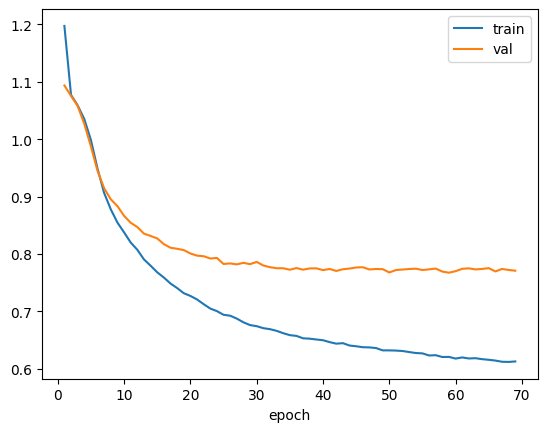

In [24]:
ax = pd.DataFrame(history_1).drop(columns='total').plot(x='epoch')
final_loss_model_1 = np.sqrt(np.mean((np.array(preds_1) - np.array(ground_truth_1))**2))
print(f'Final RMSE: {final_loss_model_1:.4f}')
recommender_system(32, model_1, 10)

## Model 2

Here I have increased the learning rate parameter (while keeping the initialization the same).  As expected, increasing the learning rate resulted in a steeper drops in loss and a larger exploration of parameter space but resulted in overfitting. 

RSME in thus higher than Model 1, though the recommendations are the similar.

In [25]:
RANDOM_STATE = 100
set_random_seed(RANDOM_STATE)

model_2_params =  dict(n_users=n,
                    n_movies=m, 
                    n_factors=150,
                    hidden=[500, 500, 500],
                    embedding_dropout=0.05,
                    dropouts=[0.5, 0.5, 0.25])

train_params_2 = dict(lr = 1e-3, wd = 1e-5, bs = 200, n_epochs = 200, patience = 10, no_improvements = 0)

model_2 = EmbeddingNet(**model_2_params)
history_2 = train_model(model_2, **train_params_2)
(preds_2, ground_truth_2) = get_evaluation_data(model_2)

loss improvement on epoch: 1
[001/200] train: 0.8421 - val: 0.7732
loss improvement on epoch: 2
[002/200] train: 0.7090 - val: 0.7541
loss improvement on epoch: 3
[003/200] train: 0.6539 - val: 0.7499
[004/200] train: 0.6077 - val: 0.7686
[005/200] train: 0.5543 - val: 0.7770
[006/200] train: 0.4961 - val: 0.8030
[007/200] train: 0.4461 - val: 0.8173
[008/200] train: 0.4028 - val: 0.8456
[009/200] train: 0.3684 - val: 0.8425
[010/200] train: 0.3406 - val: 0.8286
[011/200] train: 0.3210 - val: 0.8396
[012/200] train: 0.3011 - val: 0.8833
[013/200] train: 0.2821 - val: 0.8570
early stopping after epoch 013


Final RMSE: 0.9285
Total movies seen by the user: 156
Some top rated movies (rating = 5.0) seen by the user:

Waiting to Exhale (1995)
Sabrina (1995)
Casino (1995)
Money Train (1995)
Leaving Las Vegas (1995)
Persuasion (1995)
Babe (1995)
Mortal Kombat (1995)
Misérables, Les (1995)
Unforgettable (1996)

Top 10 Movie recommendations for the user 32 are:

Toy Story (1995)
Jumanji (1995)
Grumpier Old Men (1995)
Father of the Bride Part II (1995)
Heat (1995)
Sudden Death (1995)
GoldenEye (1995)
American President, The (1995)
Balto (1995)
Nixon (1995)


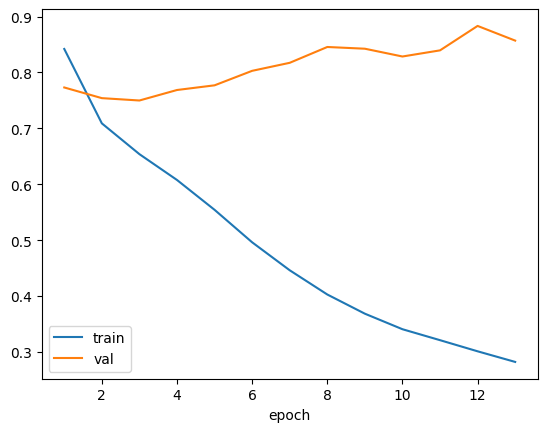

In [26]:
ax = pd.DataFrame(history_2).drop(columns='total').plot(x='epoch')
final_loss_model_2 = np.sqrt(np.mean((np.array(preds_2) - np.array(ground_truth_2))**2))
print(f'Final RMSE: {final_loss_model_2:.4f}')
recommender_system(32, model_2, 10)

## Model 3

Reduced the number of hidden units by half.  Overall, this model generated similar results as Model 1. This is also expected, since the number of hidden units is not needed given the relatively small data set and relatively small number of dimensions of the feature vectors.


In [30]:
RANDOM_STATE = 100
set_random_seed(RANDOM_STATE)

model_3_params =  dict(n_users=n,
                    n_movies=m, 
                    n_factors=150,
                    hidden=[250, 250, 250],
                    embedding_dropout=0.05,
                    dropouts=[0.5, 0.5, 0.25])

train_params_3 = dict(lr = 1e-5, wd = 1e-5, bs = 200, n_epochs = 200, patience = 10, no_improvements = 0)

model_3 = EmbeddingNet(**model_3_params)
history_3 = train_model(model_3, **train_params_3)
(preds_3, ground_truth_3) = get_evaluation_data(model_3)

loss improvement on epoch: 1
[001/200] train: 1.3622 - val: 1.1539
loss improvement on epoch: 2
[002/200] train: 1.1011 - val: 1.0871
loss improvement on epoch: 3
[003/200] train: 1.0751 - val: 1.0736
loss improvement on epoch: 4
[004/200] train: 1.0602 - val: 1.0567
loss improvement on epoch: 5
[005/200] train: 1.0407 - val: 1.0415
loss improvement on epoch: 6
[006/200] train: 1.0160 - val: 1.0156
loss improvement on epoch: 7
[007/200] train: 0.9856 - val: 0.9825
loss improvement on epoch: 8
[008/200] train: 0.9526 - val: 0.9545
loss improvement on epoch: 9
[009/200] train: 0.9159 - val: 0.9286
loss improvement on epoch: 10
[010/200] train: 0.8889 - val: 0.9060
loss improvement on epoch: 11
[011/200] train: 0.8626 - val: 0.8922
loss improvement on epoch: 12
[012/200] train: 0.8461 - val: 0.8765
loss improvement on epoch: 13
[013/200] train: 0.8319 - val: 0.8705
loss improvement on epoch: 14
[014/200] train: 0.8192 - val: 0.8564
loss improvement on epoch: 15
[015/200] train: 0.8066 - v

Final RMSE: 0.8843
Total movies seen by the user: 156
Some top rated movies (rating = 5.0) seen by the user:

Waiting to Exhale (1995)
Sabrina (1995)
Casino (1995)
Money Train (1995)
Leaving Las Vegas (1995)
Persuasion (1995)
Babe (1995)
Mortal Kombat (1995)
Misérables, Les (1995)
Unforgettable (1996)

Top 10 Movie recommendations for the user 32 are:

Toy Story (1995)
Jumanji (1995)
Grumpier Old Men (1995)
Father of the Bride Part II (1995)
Heat (1995)
Sudden Death (1995)
GoldenEye (1995)
American President, The (1995)
Balto (1995)
Nixon (1995)


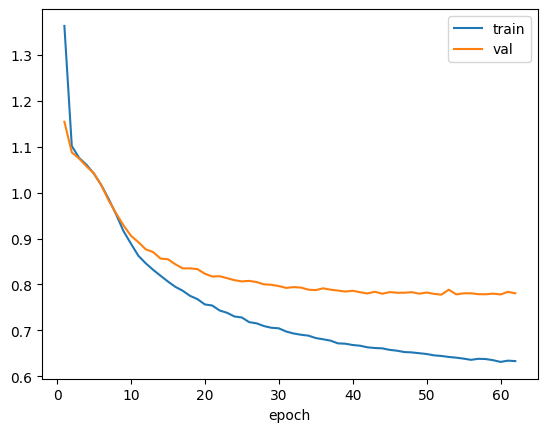

In [31]:
ax = pd.DataFrame(history_3).drop(columns='total').plot(x='epoch')
final_loss_model_3 = np.sqrt(np.mean((np.array(preds_3) - np.array(ground_truth_3))**2))
print(f'Final RMSE: {final_loss_model_3:.4f}')
recommender_system(32, model_3, 10)